# Benchmarking randomized circuits using Quantum state tomography

In [1]:
def benchmark_rc_circuit(original_circuit, randomized_circuits, measurement_qubits, backend, dpi=None):
    from qiskit_experiments.library import StateTomography
    from qiskit.quantum_info import DensityMatrix, state_fidelity, Statevector, partial_trace, purity
    from qiskit.visualization.utils import _bloch_multivector_data
    from qiskit.visualization.bloch import Bloch
    from matplotlib import pyplot as plt

    n = original_circuit.num_qubits
    density_matrices = []

    for circ in randomized_circuits:
        qstexp = StateTomography(circ, measurement_qubits=measurement_qubits)
        qstdata = qstexp.run(backend, shots=500).block_for_results()
        density_matrices.append(qstdata.analysis_results('state').value)

    bloch_data = [_bloch_multivector_data(density_matrix) for density_matrix in density_matrices]
    average_dm = DensityMatrix(sum([dm.data for dm in density_matrices]) / len(density_matrices))

    target_state = Statevector.from_instruction(original_circuit)
    target_dm = partial_trace(target_state, [i for i in range(n) if i not in measurement_qubits])
    fidelity_list = [state_fidelity(target_dm, dm) for dm in density_matrices]
    purity_list = [purity(dm) for dm in density_matrices]
    fidelity = state_fidelity(target_dm, average_dm)

    average_vectors = _bloch_multivector_data(average_dm)
    target_vectors = _bloch_multivector_data(target_dm)

    # Source code taken from https://qiskit.org/documentation/_modules/qiskit/visualization/state_visualization.html#plot_bloch_multivector
    num = len(bloch_data[0])
    width, height = plt.figaspect(1 / num)
    fig = plt.figure(figsize=(width, height), dpi=dpi)

    ax_list = [fig.add_subplot(1, num, i + 1, projection="3d") for i in range(num)]
    for i in range(num):
        B = Bloch(axes=ax_list[i])
        B.vector_width = 3
        B.vector_mutation = 5
        B.point_marker = ['o']
        B.point_size = [5]
        B.point_color = ['y']
        for j in range(len(randomized_circuits)):
            B.add_points(bloch_data[j][i], 'm')
        B.add_vectors(average_vectors[i])
        B.add_vectors(target_vectors[i])
        B.render()

    print(f'The blue arrow corresponds to the ideal result.')
    print(f'Fidelity of the red arrow: {fidelity}')
    print(f'Fidelity of the points: {fidelity_list}')
    print(f'Purities of the points: {purity_list}')

    return fig

In [2]:
def tvd_benchmark_rc_circuit(original_circuit, randomized_circuits, backend, shots_per_randomized_circuit = 500):
    from qiskit import execute
    from qiskit.quantum_info import Statevector

    n_random_circs = len(randomized_circuits)
    total_shots = n_random_circs * shots_per_randomized_circuit

    state_vector = Statevector.from_instruction(original_circuit)
    ideal_probabilities = state_vector.probabilities_dict()

    original_circuit_ = original_circuit.copy()
    original_circuit_.measure_all()
    bare_counts = execute(original_circuit_, backend, shots=n_random_circs * shots_per_randomized_circuit).result().get_counts()
    bare_counts = {key: value for key, value in sorted(bare_counts.items())}

    rc_counts_list = []
    for rc in randomized_circuits:
        rc_ = rc.copy()
        rc_.measure_all()
        rc_counts_list.append(execute(rc_, backend, shots=shots_per_randomized_circuit).result().get_counts())
    keys = set().union(*rc_counts_list)
    rc_counts = {k: sum([cnts.get(k, 0) for cnts in rc_counts_list]) for k in keys}
    rc_counts = {key: value for key, value in sorted(rc_counts.items())}

    tvd_bare = sum(0.5 * abs(ideal_probabilities.get(key, 0) - bare_counts.get(key, 0) / total_shots)
                   for key in ideal_probabilities.keys() | bare_counts.keys())
    tvd_random = sum(0.5 * abs(ideal_probabilities.get(key, 0) - rc_counts.get(key, 0) / total_shots)
                     for key in ideal_probabilities.keys() | rc_counts.keys())

    print(ideal_probabilities)
    print('Original TVD: ', tvd_bare, bare_counts)
    print('Randomized TVD: ', tvd_random, rc_counts)

In [189]:
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import numpy as np

# Code taken from https://quantumcomputing.stackexchange.com/questions/22149/replace-gate-with-known-identity-in-quantum-circuit
class RtoPauliTranslator(TransformationPass):
    def run(self, dag):
        """Run the pass."""

        # iterate over all operations
        for node in dag.op_nodes():
            print(node.op)

            if node.op.name in ["rx", "ry", "rz"]:
                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rx" and abs(node.op.params[0]) == np.pi:
                    replacement.x(0)
                elif node.op.name == "ry" and abs(node.op.params[0]) == np.pi:
                    replacement.y(0)
                elif node.op.name == "rz" and abs(node.op.params[0]) == np.pi:
                    replacement.z(0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))

        return dag

In [190]:
def randomized_circuit(q_input, circ_number, max_iter):
    from qiskit.compiler import transpile
    from qiskit import QuantumCircuit
    from qiskit.circuit.library import XGate, YGate, ZGate, IGate
    import numpy as np

    ## define easy and hard gates

    easy_gate = ['id', 'x', 'y', 'z']
    hard_gate = ['cz', 't', 'h']
    basis_gate = easy_gate + hard_gate + ['rz']

    ## transpile the input gate to the equivalent gate with easy and hard gates basis

    q_transform = q_input
    # q_transform = transpile(q_input, basis_gates=basis_gate)

    random_circuit_set = []

    ## set easy_layer sets and hard_layer sets
    easy_layer = []
    hard_layer = []
    easy_layer_comp = []
    hard_seeker = False
    for gate in q_transform.data:
        if gate[0].name in hard_gate:
            hard_layer.append(gate)
            hard_seeker=True
            easy_layer.append(easy_layer_comp)
            easy_layer_comp=[]
        elif gate[0].name in easy_gate:
            if hard_seeker:
                hard_seeker=False
                easy_layer_comp=[]
            easy_layer_comp.append(gate)
    easy_layer.append(easy_layer_comp)

    def random_T():
        rand_value = np.random.randint(4)
        if rand_value == 0:
            return XGate()
        elif rand_value == 1:
            return YGate()
        elif rand_value == 2:
            return ZGate()
        else:
            return IGate()

    depth_easy = len(easy_layer)
    depth_hard = len(hard_layer)
    depth = depth_easy + depth_hard

    for _ in np.arange(circ_number):
        T_set = []
        for _ in range(depth_hard):
            T_comp = []
            for _ in np.arange(q_transform.num_qubits):
                T = random_T()
                T_comp.append(T)
            T_set.append(T_comp)

        q_out = QuantumCircuit(q_transform.num_qubits)
        for ind in range(depth//2 + 1):
            # Hard layer
            if ind > 0:
                q_out.barrier()
                q_out.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
                q_out.barrier()
            # Tc + easy + T layer (No Tc at the first layer, no T at the final layer)
            ## Tc
            q_temp = QuantumCircuit(q_transform.num_qubits)
            if ind > 0:
                q_temp.compose(hard_layer[ind - 1][0].reverse_ops(), hard_layer[ind - 1][1], inplace=True)
                for T_ind in np.arange(len(T_set[ind - 1])):
                    q_out.compose(T_set[ind - 1][T_ind].reverse_ops(), [T_ind], inplace=True)
                q_temp.compose(hard_layer[ind - 1][0], hard_layer[ind - 1][1], inplace=True)
            ## easy
            for sub_ind in np.arange(len(easy_layer[ind])):
                q_temp.compose(easy_layer[ind][sub_ind][0], easy_layer[ind][sub_ind][1], inplace=True)
            ## T
            if (ind < depth//2):
                for T_ind in np.arange(len(T_set[ind])):
                    q_temp.compose(T_set[ind][T_ind], [T_ind], inplace=True)

            q_out.compose(q_temp, range(q_transform.num_qubits), inplace=True)

        # q_final = transpile(q_out, basis_gates=['id', 'x', 'y', 'z', 'rz', 't', 'h', 'cz'], optimization_level=0)

        from qiskit.compiler import transpile

        q_out = transpile(q_out, basis_gates=['id', 'u3', 'cz'], optimization_level=3)
        q_out = transpile(q_out, basis_gates=['rx', 'rz', 'ry', 'cz', 'id'], optimization_level=3)
        q_out = RtoPauliTranslator()(q_out)

        random_circuit_set.append(q_out)

    return random_circuit_set

Instruction(name='rx', num_qubits=1, num_clbits=0, params=[-3.141592653589793])
Instruction(name='ry', num_qubits=1, num_clbits=0, params=[3.1415926535897927])
Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[])
Instruction(name='cz', num_qubits=2, num_clbits=0, params=[])
Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-3.141592653589793])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[-3.141592653589793])
Instruction(name='rx', num_qubits=1, num_clbits=0, params=[-3.141592653589793])
Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[])
Instruction(name='cz', num_qubits=2, num_clbits=0, params=[])
Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[])
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-3.141592653589793])
Instruction(name='ry', num_qubits=1, num_clbits=0, params=[3.1415926535897927])
Instruction(name='ry', num_qubits=1, num_clbits=

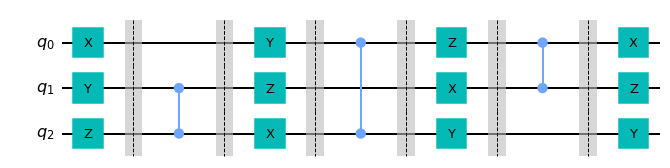

In [191]:
# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.circuit.library import QFT

target = QuantumCircuit(3)
target.x(0)
target.y(1)
target.z(2)
target.barrier()
target.cz(1, 2)
target.barrier()
target.y(0)
target.z(1)
target.x(2)
target.barrier()
target.cz(2, 0)
target.barrier()
target.z(0)
target.x(1)
target.y(2)
target.barrier()
target.cz(0, 1)
target.barrier()
target.x(0)
target.z(1)
target.y(2)

# target = transpile(target, basis_gates=['id', 'x', 'y', 'z', 'cz', 'h', 't', 'rz'], optimization_level=0)

rc_circs = randomized_circuit(target, 10, 1)

target.draw('mpl')

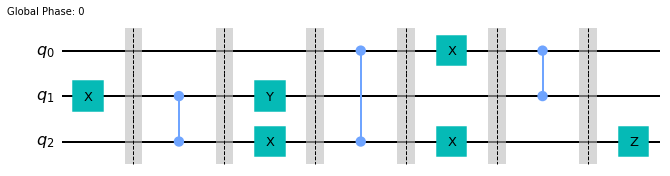

In [196]:
rc_circs[8].draw('mpl')

In [ ]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import coherent_unitary_error
from qiskit.circuit.library import RZGate, RXGate

# QuantumError objects
error_overrot = coherent_unitary_error(RXGate(0.0001).to_matrix())

# Add errors to noise model
coherent_errors = NoiseModel(basis_gates=['id', 'x', 'y', 'z', 's', 'cx', 'rz'])
coherent_errors.add_all_qubit_quantum_error(error_overrot, ['x', 'y', 'z'])

backend = AerSimulator(noise_model=coherent_errors)
# backend = FakeParis()

tvd_benchmark_rc_circuit(target, rc_circs, backend=backend, shots_per_randomized_circuit=10000)
# fig = benchmark_rc_circuit(target, rc_circs, measurement_qubits=[0, 1, 2], backend=backend, dpi=200)